# Part 3, Model 3: Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) on the fundus, the optic cup, and the optic disk images of the eye + calculated OC feature + calculated OD feature + computed I-GRI (Integrated Glaucoma Risk Index) feature (predictive imputation used to fill up NaN values) using statistical analysis. The features were extracted using the MobileNetV3 model.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-02-25 15:33:22.952836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 15:33:22.953017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 15:33:22.968932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 15:33:23.024851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 15:33:24.533968: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# know column type
data['fundus_oc_seg'].dtype

dtype('O')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [9]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


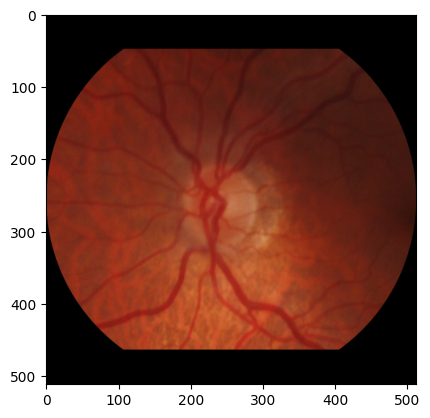

optic-cup/optic-cup/PAPILA-484.png


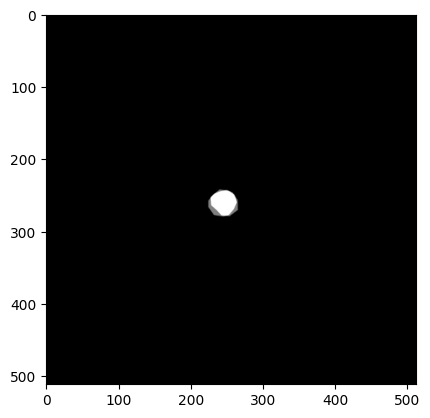

optic-disc/optic-disc/PAPILA-484.png


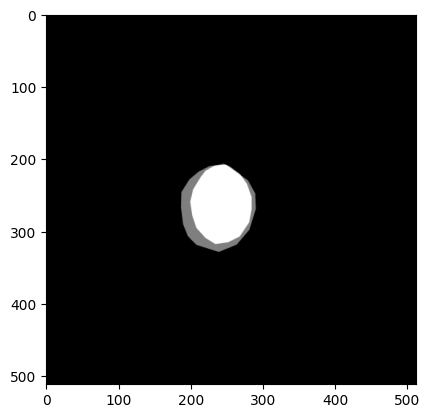

In [10]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])
viewOpticDisc(data['fundus_od_seg'][12044])

In [11]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data['eye'] = data['eye'].replace({'OD': 0, 'OS': 1})

data[['eye']].value_counts()

eye
1.0    2925
0.0    2808
Name: count, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

numerical_data = data.select_dtypes(include=[np.number])  

for col in numerical_data.columns:
    if numerical_data[col].isna().all():
        numerical_data[col].fillna(0, inplace=True) 

print("Number of columns before imputation:", numerical_data.shape[1])

imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)

numerical_data_imputed = imp.fit_transform(numerical_data)

print("Shape of imputed data:", numerical_data_imputed.shape)

numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

non_numerical_data = data.select_dtypes(exclude=[np.number]) 
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

data_imputed = data_imputed.loc[data.index]

Number of columns before imputation: 25


Shape of imputed data: (12449, 25)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [15]:
print(data_imputed.describe())

              types  isColor        gender          age           eye  \
count  12449.000000  12449.0  12449.000000  12449.00000  12449.000000   
mean       0.372239      1.0      0.512009     58.61371      0.568665   
std        0.505039      0.0      0.499876      8.00854      0.494991   
min       -1.000000      1.0      0.000000      1.00000      0.000000   
25%        0.000000      1.0      0.000000     57.96000      0.000000   
50%        0.000000      1.0      1.000000     61.00000      1.000000   
75%        1.000000      1.0      1.000000     61.00000      1.000000   
max        1.000000      1.0      1.000000     91.00000      1.000000   

                sbp           dbp            hr           iop          vcdr  \
count  12449.000000  12449.000000  12449.000000  12449.000000  12449.000000   
mean     184.421737     83.487626     67.375363     14.877377      0.602147   
std       81.086138      5.745513      3.922181      2.607080      0.072608   
min      107.000000     47

In [16]:
data_imputed[["eye"]].value_counts()

eye 
1.00    7073
0.00    5351
0.04      10
0.33       5
0.02       1
0.34       1
0.35       1
0.36       1
0.37       1
0.38       1
0.51       1
0.57       1
0.65       1
0.71       1
Name: count, dtype: int64

In [17]:
data_imputed['eye'] = data_imputed['eye'].round().astype(int)

In [18]:
data_imputed[["eye"]].value_counts()

eye
1      7077
0      5372
Name: count, dtype: int64

In [19]:
data = data_imputed

data

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,0.0,1.0,1.0,58.00,0,327.99,88.16,65.83,13.65,0.549382,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,1.0,60.00,1,133.10,88.35,67.64,13.90,0.564799,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,1.0,66.00,1,128.70,80.15,66.00,13.34,0.669609,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,1.0,1.0,70.00,0,149.79,87.89,68.28,14.37,0.593762,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.0,0.0,45.00,1,207.00,88.39,67.15,19.41,0.542203,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,0.0,1.0,1.0,57.96,0,327.99,88.16,65.83,13.65,0.554832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,0.0,1.0,1.0,57.96,0,327.99,88.16,65.83,13.65,0.554832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,0.0,1.0,1.0,57.96,0,327.99,88.16,65.83,13.65,0.554832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,0.0,1.0,1.0,57.96,0,327.99,88.16,65.83,13.65,0.554832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data[["age"]].value_counts()

age  
61.00    4293
57.96    2531
56.00     239
62.00     208
60.00     206
         ... 
56.73       1
56.77       1
56.83       1
56.94       1
91.00       1
Name: count, Length: 408, dtype: int64

optic-cup/optic-cup/PAPILA-484.png
optic-cup/optic-cup/PAPILA-484.png


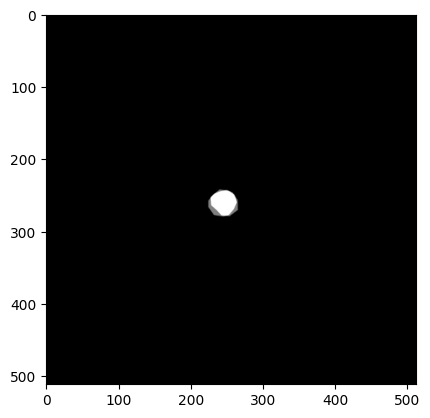

Normalized OC Area: 0.004856109619140625


In [21]:
import cv2
import numpy as np

def compute_normalized_area_optic_cup(masked_image_path):

    try:

        masked_image_path = 'optic-cup' + masked_image_path

        print(masked_image_path)


        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_cup(data['fundus_oc_seg'][12044])

viewOpticCup(data['fundus_oc_seg'][12044])

print(f"Normalized OC Area: {normalized_area}")

optic-disc/optic-disc/PAPILA-484.png
optic-disc/optic-disc/PAPILA-484.png


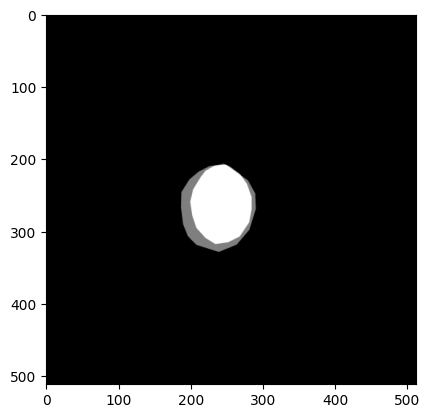

Normalized OD Area: 0.037567138671875


In [22]:
import cv2
import numpy as np

def compute_normalized_area_optic_disc(masked_image_path):

    try:

        masked_image_path = 'optic-disc' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

# Compute normalized area
normalized_area = compute_normalized_area_optic_disc(data['fundus_od_seg'][12044])

viewOpticDisc(data['fundus_od_seg'][12044])

print(f"Normalized OD Area: {normalized_area}")

In [23]:
data[["fundus", "fundus_oc_seg", "fundus_od_seg"]].describe()

,fundus,fundus_oc_seg,fundus_od_seg
count,12449,3103,3103
unique,12449,2875,3103
top,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,Not Visible,/optic-disc/ORIGA-1.png
freq,1,229,1


In [24]:
data = data[data['fundus_oc_seg'] != 'Not Visible']

In [25]:
data[["fundus", "fundus_oc_seg", "fundus_od_seg"]].describe()

,fundus,fundus_oc_seg,fundus_od_seg
count,12220,2874,2874
unique,12220,2874,2874
top,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png
freq,1,1,1


In [26]:
data = data [

    (data['fundus'].notnull()) &
    (data['fundus_oc_seg'].notnull()) & 
    (data['fundus_od_seg'].notnull()) & (data['types'] != -1)
]

fundus_subset = data[['types', 'fundus', 'fundus_oc_seg', 'fundus_od_seg', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2805 entries, 4546 to 12048
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   types          2805 non-null   object
 1   fundus         2805 non-null   object
 2   fundus_oc_seg  2805 non-null   object
 3   fundus_od_seg  2805 non-null   object
 4   names          2805 non-null   object
 5   combined       2805 non-null   object
dtypes: object(6)
memory usage: 153.4+ KB


/tmp/ipykernel_11308/2187337796.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_11308/2187337796.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_11308/2187337796.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [27]:
import cv2
import numpy as np
import pandas as pd

data['OC size'] = 0.0

for index, row in data.iterrows():
    normalized_area = compute_normalized_area_optic_cup(row['fundus_oc_seg'])
    data.at[index, 'OC size'] = normalized_area

optic-cup/optic-cup/ORIGA-1.png
optic-cup/optic-cup/ORIGA-2.png
optic-cup/optic-cup/ORIGA-3.png
optic-cup/optic-cup/ORIGA-4.png
optic-cup/optic-cup/ORIGA-5.png
optic-cup/optic-cup/ORIGA-6.png
optic-cup/optic-cup/ORIGA-7.png
optic-cup/optic-cup/ORIGA-8.png
optic-cup/optic-cup/ORIGA-9.png
optic-cup/optic-cup/ORIGA-10.png
optic-cup/optic-cup/ORIGA-11.png
optic-cup/optic-cup/ORIGA-12.png
optic-cup/optic-cup/ORIGA-13.png
optic-cup/optic-cup/ORIGA-14.png
optic-cup/optic-cup/ORIGA-15.png
optic-cup/optic-cup/ORIGA-16.png
optic-cup/optic-cup/ORIGA-17.png
optic-cup/optic-cup/ORIGA-18.png
optic-cup/optic-cup/ORIGA-19.png
optic-cup/optic-cup/ORIGA-20.png
optic-cup/optic-cup/ORIGA-21.png
optic-cup/optic-cup/ORIGA-22.png
optic-cup/optic-cup/ORIGA-23.png
optic-cup/optic-cup/ORIGA-24.png
optic-cup/optic-cup/ORIGA-25.png
optic-cup/optic-cup/ORIGA-26.png
optic-cup/optic-cup/ORIGA-27.png
optic-cup/optic-cup/ORIGA-28.png
optic-cup/optic-cup/ORIGA-29.png


optic-cup/optic-cup/ORIGA-30.png
optic-cup/optic-cup/ORIGA-31.png
optic-cup/optic-cup/ORIGA-32.png
optic-cup/optic-cup/ORIGA-33.png
optic-cup/optic-cup/ORIGA-34.png
optic-cup/optic-cup/ORIGA-35.png
optic-cup/optic-cup/ORIGA-36.png
optic-cup/optic-cup/ORIGA-37.png
optic-cup/optic-cup/ORIGA-38.png
optic-cup/optic-cup/ORIGA-39.png
optic-cup/optic-cup/ORIGA-40.png
optic-cup/optic-cup/ORIGA-41.png
optic-cup/optic-cup/ORIGA-42.png
optic-cup/optic-cup/ORIGA-43.png
optic-cup/optic-cup/ORIGA-44.png
optic-cup/optic-cup/ORIGA-45.png
optic-cup/optic-cup/ORIGA-46.png
optic-cup/optic-cup/ORIGA-47.png
optic-cup/optic-cup/ORIGA-48.png
optic-cup/optic-cup/ORIGA-49.png
optic-cup/optic-cup/ORIGA-50.png
optic-cup/optic-cup/ORIGA-51.png
optic-cup/optic-cup/ORIGA-52.png
optic-cup/optic-cup/ORIGA-53.png
optic-cup/optic-cup/ORIGA-54.png
optic-cup/optic-cup/ORIGA-55.png
optic-cup/optic-cup/ORIGA-56.png
optic-cup/optic-cup/ORIGA-57.png
optic-cup/optic-cup/ORIGA-58.png
optic-cup/optic-cup/ORIGA-59.png
optic-cup/

In [28]:
import cv2
import numpy as np
import pandas as pd

data['OD size'] = 0.0  

for index, row in data.iterrows():
    normalized_area = compute_normalized_area_optic_disc(row['fundus_od_seg'])
    data.at[index, 'OD size'] = normalized_area

optic-disc/optic-disc/ORIGA-1.png
optic-disc/optic-disc/ORIGA-2.png
optic-disc/optic-disc/ORIGA-3.png
optic-disc/optic-disc/ORIGA-4.png
optic-disc/optic-disc/ORIGA-5.png
optic-disc/optic-disc/ORIGA-6.png
optic-disc/optic-disc/ORIGA-7.png
optic-disc/optic-disc/ORIGA-8.png
optic-disc/optic-disc/ORIGA-9.png
optic-disc/optic-disc/ORIGA-10.png
optic-disc/optic-disc/ORIGA-11.png
optic-disc/optic-disc/ORIGA-12.png
optic-disc/optic-disc/ORIGA-13.png
optic-disc/optic-disc/ORIGA-14.png
optic-disc/optic-disc/ORIGA-15.png
optic-disc/optic-disc/ORIGA-16.png
optic-disc/optic-disc/ORIGA-17.png
optic-disc/optic-disc/ORIGA-18.png
optic-disc/optic-disc/ORIGA-19.png
optic-disc/optic-disc/ORIGA-20.png
optic-disc/optic-disc/ORIGA-21.png
optic-disc/optic-disc/ORIGA-22.png
optic-disc/optic-disc/ORIGA-23.png
optic-disc/optic-disc/ORIGA-24.png
optic-disc/optic-disc/ORIGA-25.png
optic-disc/optic-disc/ORIGA-26.png
optic-disc/optic-disc/ORIGA-27.png
optic-disc/optic-disc/ORIGA-28.png
optic-disc/optic-disc/ORIGA-2

In [29]:
data

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect,OC size,OD size
4546,0.0,1.0,1.0,44.79,0,207.62,88.57,66.18,18.85,0.709700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010849,0.022560
4547,0.0,1.0,1.0,64.55,1,131.46,81.19,66.10,19.06,0.695300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010250,0.020405
4548,0.0,1.0,1.0,55.44,1,157.00,76.94,57.01,17.95,0.962900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019222,0.020947
4549,0.0,1.0,1.0,40.87,0,207.77,88.57,66.18,18.85,0.724600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008072,0.015347
4550,0.0,1.0,1.0,57.47,1,135.87,89.28,67.77,19.37,0.613800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008331,0.018131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,0.0,1.0,0.0,64.00,1,124.45,68.09,66.34,13.15,0.617075,...,-1.5,93,1,10,,531,22.31,,0.004856,0.037567
12045,0.0,1.0,1.0,75.00,1,151.83,80.57,66.71,14.37,0.549902,...,-0.25,160,1,19,,573,22.01,,0.004936,0.039188
12046,0.0,1.0,0.0,55.00,1,135.94,88.47,67.39,19.62,0.532218,...,-1.25,76,0,14,,443,23.51,,0.002399,0.024658
12047,0.0,1.0,1.0,56.00,1,195.46,88.18,67.38,13.41,0.528262,...,-0.75,79,0,9,,479,23.84,,0.006138,0.028481


In [30]:
fundus_subset['types'].value_counts()

types
0.0    2140
1.0     665
Name: count, dtype: int64

In [31]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
4546,0.0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,ORIGA-1.png
4547,0.0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,ORIGA-2.png
4548,0.0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,ORIGA-3.png
4549,0.0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,ORIGA-4.png
4550,0.0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,ORIGA-5.png
...,...,...,...,...,...,...
12044,0.0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,PAPILA-484.png
12045,0.0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,PAPILA-485.png
12046,0.0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,PAPILA-486.png
12047,0.0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,PAPILA-487.png


In [32]:
fundus_subset.describe()

,types,fundus,fundus_oc_seg,fundus_od_seg,names,combined
count,2805,2805,2805,2805,2805,2805
unique,2,2805,2805,2805,2805,2805
top,0.0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,ORIGA-1.png
freq,2140,1,1,1,1,1


In [33]:
glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1.0'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0.0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

test_percentage = 0.15  
val_percentage_from_train = 0.05  

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(fundus_subset['types']),
                y=fundus_subset['types'].values)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

random_state = 1

# Create StratifiedShuffleSplit instance for test set with percentage
stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

# Create StratifiedShuffleSplit instance for validation set with percentage
stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

# Print the counts for each set and total
print("\nTotal fundus images to be used:", len(fundus_subset))
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

# Print class weights
print("\nClass weights for model training:")
print(class_weights_dict)

# You can access the features and labels as needed
train_features = train.drop('types', axis=1)  
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 665
this is the healthy eyes count 2140

Total fundus images to be used: 2805
Train set size: 2264
Validation set size: 120
Test set size: 421

Class weights for model training:
{0: 0.655373831775701, 1: 2.1090225563909772}


In [34]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  2264
Test Size:  421


In [35]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-25 15:35:14.794354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 15:35:15.241978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 15:35:15.242361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [36]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen1 = trainDataGen1.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen1 = valDataGen1.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen1 = testDataGen1.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-02-25 15:35:15.261289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 15:35:15.262237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 15:35:15.262898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 15:35:15.474922: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-25 15:35:15.475416: I external/local_xla/xla/stream_executor

Found 2264 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 421 validated image filenames belonging to 2 classes.


In [37]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen2 = trainDataGen2.flow_from_dataframe(dataframe=train, 
                                                directory='optic-cup/optic-cup', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen2 = valDataGen2.flow_from_dataframe(dataframe=val,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen2 = testDataGen2.flow_from_dataframe(dataframe=test,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2264 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 421 validated image filenames belonging to 2 classes.


In [38]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen3 = trainDataGen3.flow_from_dataframe(dataframe=train, 
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen3 = valDataGen3.flow_from_dataframe(dataframe=val,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen3 = testDataGen3.flow_from_dataframe(dataframe=test,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2264 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 421 validated image filenames belonging to 2 classes.


In [39]:
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0.0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1.0']

with tf.device('/GPU:0'):

    classes = 'sparse'

    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = healthy_subsetDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 2140 validated image filenames belonging to 1 classes.
Found 665 validated image filenames belonging to 1 classes.


In [40]:
def show_images(gen):
    
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

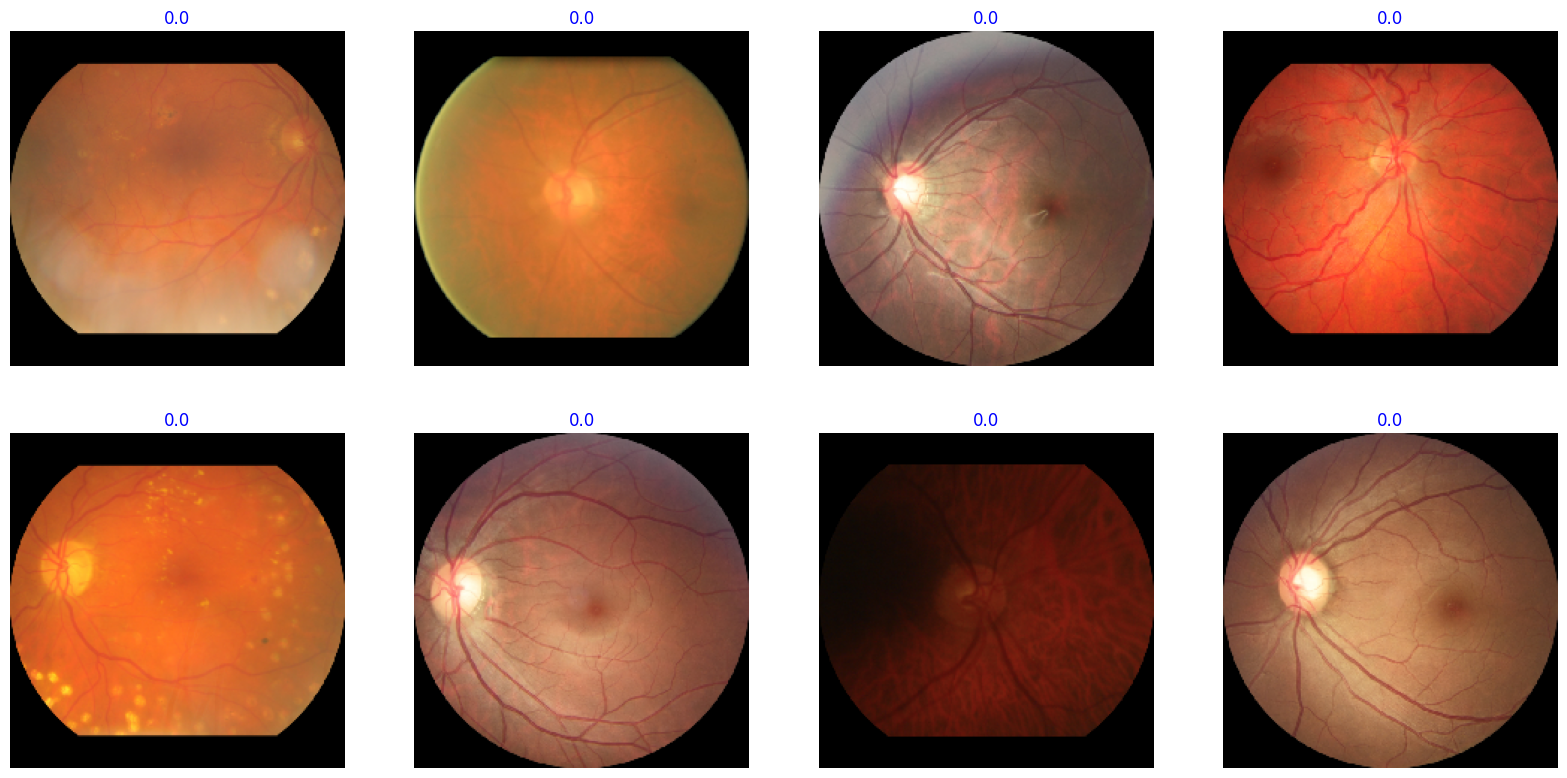

In [41]:
show_images(healthy_subset_Gen)

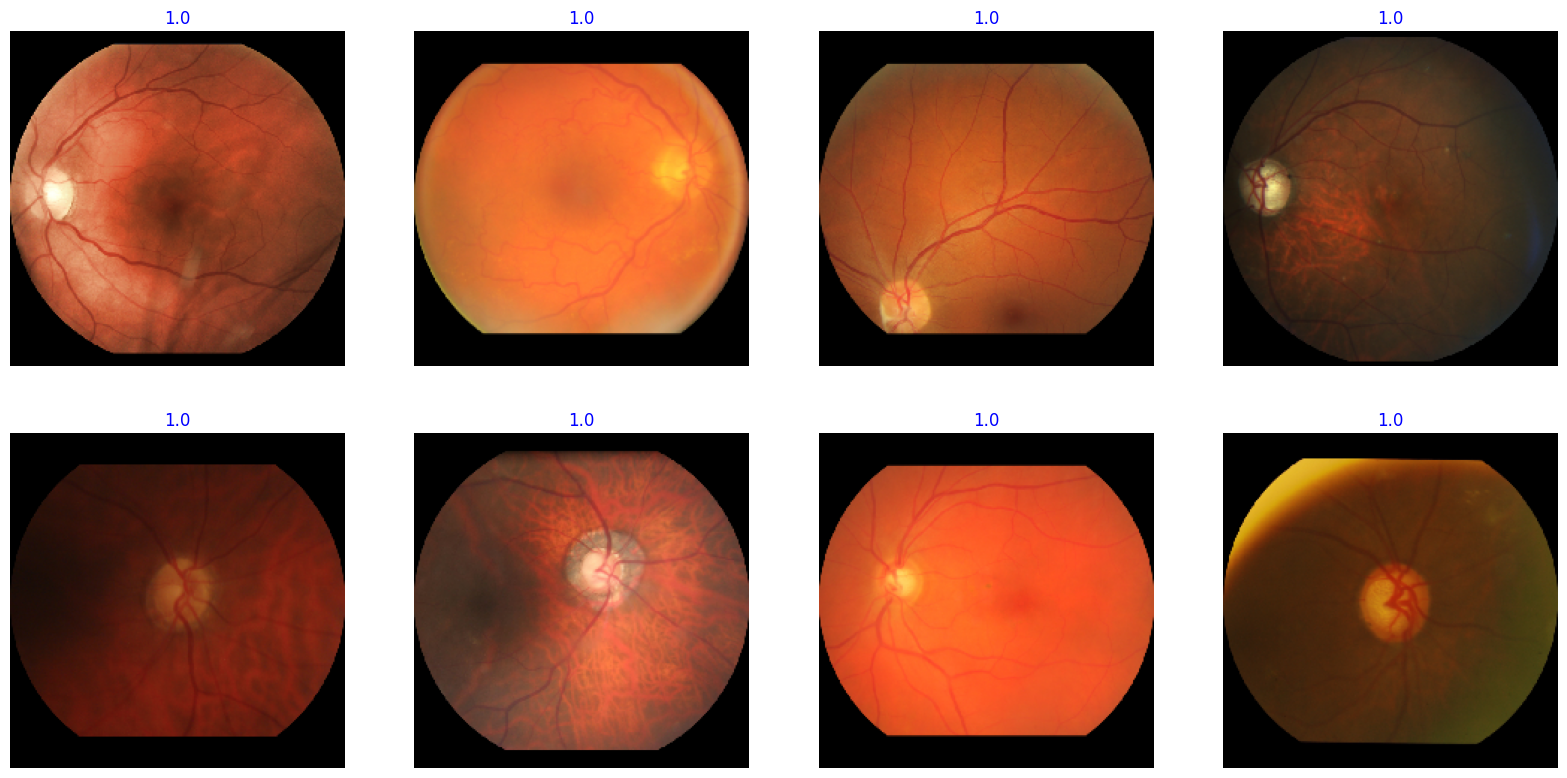

In [47]:
show_images(glaucoma_subset_Gen)

In [48]:
from keras.applications import MobileNetV3Small
from keras import Sequential

# Load pre-trained MobileNetV3 model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

model = Sequential([
    base_model, layers.GlobalAveragePooling2D()
])

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

In [49]:
import numpy as np

for column in ['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

weights = {
    'gender': 0.05,
    'age': 0.1,
    'eye': 0.05,
    'sbp': 0.08,
    'dbp': 0.08,
    'hr': 0.05,
    'iop': 0.15,
    'vcdr': 0.15,
    'cdr_avg': 0.15,
    'OC_size': 0.14,
    'OD_size': 0.16
}

data['I-GRI'] = np.sum(data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']] * list(weights.values()),axis=1)

In [50]:
data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'I-GRI']].head()

,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,I-GRI
4546,1.0,0.455376,0.0,0.416376,0.874389,0.460752,0.861440,0.684250,0.735683,0.272610,0.322588,0.653822
4547,1.0,0.693416,1.0,0.047598,0.684427,0.458113,0.880583,0.666293,0.743172,0.257007,0.277283,0.674663
4548,1.0,0.583672,1.0,0.171267,0.575032,0.158311,0.779398,1.000000,0.749559,0.490757,0.288670,0.720223
4549,1.0,0.408153,0.0,0.417102,0.874389,0.460752,0.861440,0.702831,0.735463,0.200258,0.170957,0.617522
4550,1.0,0.608126,1.0,0.068952,0.892664,0.513193,0.908842,0.564659,0.732687,0.207016,0.229492,0.660031


In [51]:
import numpy as np

non_image_features = data[['gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size', 'I-GRI']]

train_features1, train_labels1 = extract_features(trainGen1, trainGen1.samples)
val_features1, val_labels1 = extract_features(valGen1, valGen1.samples)
test_features1, test_labels1 = extract_features(testGen1, testGen1.samples)

train_features2, train_labels2 = extract_features(trainGen2, trainGen2.samples)
val_features2, val_labels2 = extract_features(valGen2, valGen2.samples)
test_features2, test_labels2 = extract_features(testGen2, testGen2.samples)

train_features3, train_labels3 = extract_features(trainGen3, trainGen3.samples)
val_features3, val_labels3 = extract_features(valGen3, valGen3.samples)
test_features3, test_labels3 = extract_features(testGen3, testGen3.samples)


def combine_all_features(features_list, non_image_data, indices):

    combined_features = np.concatenate(features_list, axis=1)
    
    non_image_features = non_image_data.iloc[indices].to_numpy()
    
    combined_features = np.concatenate((combined_features, non_image_features), axis=1)
    
    return combined_features


train_features_combined = combine_all_features(
    [train_features1, train_features2, train_features3],
    non_image_features,
    trainGen1.index_array 
)

val_features_combined = combine_all_features(
    [val_features1, val_features2, val_features3],
    non_image_features,
    valGen1.index_array
)

test_features_combined = combine_all_features(
    [test_features1, test_features2, test_features3],
    non_image_features,
    testGen1.index_array
)

train_labels = train_labels1
val_labels = val_labels1
test_labels = test_labels1


1/1 [==============================] - 0s 22ms/step


In [52]:
train_features_combined

array([[-0.0185918 ,  1.24539888, -0.06882498, ...,  0.11121049,
         0.23566675,  0.52469332],
       [ 0.12068513,  2.29609251, -0.05889931, ...,  0.05048698,
         0.17961671,  0.4856362 ],
       [ 0.03146748,  8.01081467,  0.04511902, ...,  0.05853707,
         0.23702991,  0.56797703],
       ...,
       [-0.01891318,  0.10082655, -0.07772617, ...,  0.27499503,
         0.32218747,  0.61190636],
       [-0.01851164,  5.84120703,  0.80527425, ...,  0.02911946,
         0.17007457,  0.48111801],
       [ 0.35409981,  6.07824373,  0.14615263, ...,  0.18137547,
         0.27824553,  0.59287012]])

In [53]:
from sklearn.svm import SVC

with tf.device('/GPU:0'):

    # Create and train the SVM
    svm_model = SVC(kernel='linear', probability=True, class_weight=class_weights_dict)
    svm_model.fit(train_features_combined, train_labels)

In [54]:
# Validate the SVM
val_accuracy = svm_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the SVM
test_accuracy = svm_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.7583333333333333
Test accuracy: 0.6864608076009501


In [55]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = svm_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[241  80]
 [ 52  48]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.79       321
         1.0       0.38      0.48      0.42       100

    accuracy                           0.69       421
   macro avg       0.60      0.62      0.60       421
weighted avg       0.72      0.69      0.70       421



In [56]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=8, 
                                 weights='distance', 
                                 algorithm='auto', 
                                 leaf_size=30, 
                                 p=2, 
                                 metric='minkowski', 
                                 n_jobs=-1)
knn_model.fit(train_features_combined, train_labels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, weights='distance')

In [57]:
# Validate the KNN
val_accuracy = knn_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the KNN
test_accuracy = knn_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.775
Test accuracy: 0.7790973871733967


In [58]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = knn_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[296  25]
 [ 68  32]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86       321
         1.0       0.56      0.32      0.41       100

    accuracy                           0.78       421
   macro avg       0.69      0.62      0.64       421
weighted avg       0.75      0.78      0.76       421



In [59]:
import xgboost as xgb

scale_pos_weight = class_weights_dict[0] / class_weights_dict[1]

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
xgb_model.fit(train_features_combined, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [60]:
# Validate the xgb model
val_accuracy = xgb_model.score(val_features_combined, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the xgb model
test_accuracy = xgb_model.score(test_features_combined, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.775
Test accuracy: 0.7648456057007126


In [61]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = xgb_model.predict(test_features_combined)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[303  18]
 [ 81  19]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86       321
         1.0       0.51      0.19      0.28       100

    accuracy                           0.76       421
   macro avg       0.65      0.57      0.57       421
weighted avg       0.72      0.76      0.72       421



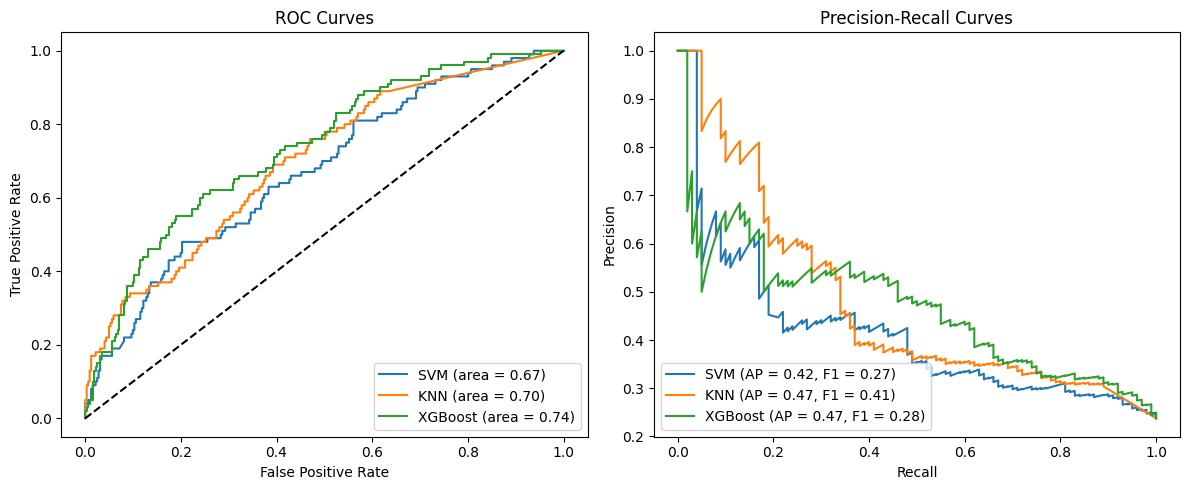

In [62]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

# Assuming you have the true labels and predicted probabilities for each model
true_labels = test_labels
svm_probs = svm_model.predict_proba(test_features_combined)[:, 1]

# KNN probabilities
knn_probs = knn_model.predict_proba(test_features_combined)[:, 1]

# XGBoost probabilities
xgb_probs = xgb_model.predict_proba(test_features_combined)[:, 1]

# Calculate ROC curve and ROC area for each model
fpr_svm, tpr_svm, _ = roc_curve(true_labels, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(true_labels, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate Precision-Recall curve and F1 score for each model
precision_svm, recall_svm, _ = precision_recall_curve(true_labels, svm_probs)
ap_svm = average_precision_score(true_labels, svm_probs)
f1_svm = f1_score(true_labels, svm_probs.round())

precision_knn, recall_knn, _ = precision_recall_curve(true_labels, knn_probs)
ap_knn = average_precision_score(true_labels, knn_probs)
f1_knn = f1_score(true_labels, knn_probs.round())

precision_xgb, recall_xgb, _ = precision_recall_curve(true_labels, xgb_probs)
ap_xgb = average_precision_score(true_labels, xgb_probs)
f1_xgb = f1_score(true_labels, xgb_probs.round())

# Plot all ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

# Plot all Precision-Recall curves
plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f}, F1 = {f1_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.2f}, F1 = {f1_knn:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f}, F1 = {f1_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()